<a href="https://colab.research.google.com/github/SaeidBrz/water-scarcity-forecasting/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -------------------
# 1. Setup & Imports
# -------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split  # (Or you can use GroupKFold if desired)
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# (Optional) Mount Google Drive if using Colab:
from google.colab import drive
drive.mount('/content/drive')

# -------------------
# 2. Read and Clean Data
# -------------------
csv_path = "/content/drive/MyDrive/merged_cleaned_10_20.csv"  # <-- Update path as needed
df = pd.read_csv(csv_path)
print("DataFrame head:")
print(df.head())

# Drop rows with NaNs
df_clean = df.dropna().reset_index(drop=True)
print("\nAfter dropping NaNs, shape:", df_clean.shape)

# -------------------
# 3. Feature Engineering: Compute 3D Cartesian Coordinates from (lat, lon)
# -------------------
df_clean['lat_rad'] = np.radians(df_clean['lat'])
df_clean['lon_rad'] = np.radians(df_clean['lon'])
df_clean['x'] = np.cos(df_clean['lat_rad']) * np.cos(df_clean['lon_rad'])
df_clean['y'] = np.cos(df_clean['lat_rad']) * np.sin(df_clean['lon_rad'])
df_clean['z'] = np.sin(df_clean['lat_rad'])

print("\nSample of computed (x, y, z):")
print(df_clean[['lat', 'lon', 'x', 'y', 'z']].head())

# -------------------
# 4. Build Grid Arrays (X and Y)
# -------------------
# Define column names for water-demand (wd_01..wd_12) and bws (bws_01..bws_12)
wd_cols = [f'wd_{i:02d}' for i in range(1, 13)]
bws_cols = [f'bws_{i:02d}' for i in range(1, 13)]

# Get sorted unique latitudes (descending) and longitudes (ascending)
unique_lats = np.sort(df_clean['lat'].unique())[::-1]
unique_lons = np.sort(df_clean['lon'].unique())
n_lat = len(unique_lats)
n_lon = len(unique_lons)
print("\nUnique lat count:", n_lat, "Unique lon count:", n_lon)

# Map lat and lon to grid indices.
lat_to_i = {lat: i for i, lat in enumerate(unique_lats)}
lon_to_j = {lon: j for j, lon in enumerate(unique_lons)}

# Initialize grid arrays:
# X: shape (n_lat, n_lon, 15) where channels 0-11 are wd_01..wd_12 and channels 12-14 are x, y, z.
# Y: shape (n_lat, n_lon, 12) corresponding to bws_01..bws_12.
X = np.zeros((n_lat, n_lon, 15), dtype=np.float32)
Y = np.zeros((n_lat, n_lon, 12), dtype=np.float32)

# Populate the grids.
for idx, row in df_clean.iterrows():
    lat_val = row['lat']
    lon_val = row['lon']
    i = lat_to_i[lat_val]
    j = lon_to_j[lon_val]

    # Fill water-demand channels.
    X[i, j, :12] = row[wd_cols].values
    # Fill x, y, z channels.
    X[i, j, 12] = row['x']
    X[i, j, 13] = row['y']
    X[i, j, 14] = row['z']

    # Fill target values (bws).
    Y[i, j, :] = row[bws_cols].values

print("\nFinal grid shapes: X =", X.shape, "Y =", Y.shape)


Mounted at /content/drive
DataFrame head:
      lon    lat     wd_01     wd_02     wd_03     wd_04     wd_05     wd_06  \
0 -179.75  65.25  0.000003  0.000003  0.000003  0.000003  0.000003  0.000003   
1 -179.75  65.75  0.000003  0.000003  0.000003  0.000003  0.000003  0.000003   
2 -179.75  66.25  0.000004  0.000004  0.000004  0.000004  0.000004  0.000004   
3 -179.75  66.75  0.000004  0.000004  0.000004  0.000004  0.000004  0.000004   
4 -179.75  67.25  0.000004  0.000004  0.000004  0.000004  0.000004  0.000004   

      wd_07     wd_08  ...    bws_03    bws_04    bws_05    bws_06    bws_07  \
0  0.000005  0.000014  ...  0.024489  0.024480  0.025420  0.025567  0.026092   
1  0.000006  0.000014  ...  0.280101  0.279974  0.290761  0.291938  0.298278   
2  0.000006  0.000014  ...  0.100148  0.100127  0.104301  0.104721  0.106981   
3  0.000006  0.000014  ...  0.000016  0.000023  0.000034  0.000058  0.000030   
4  0.000006  0.000014  ...  0.000019  0.000033  0.000042  0.000068  0.000034 

In [ ]:

# -------------------
# 5. Extract 9x9 Patches and Record Patch Center Indices
# -------------------
patch_size = 3
half_size = patch_size // 2  # For a 9x9 patch, half_size = 4

patches_X = []
patches_Y = []
patch_center_i = []  # will store the grid row index (lat index) for the patch center
patch_center_j = []  # will store the grid column index (lon index) for the patch center

# Use a nested loop with stride = 1 (as in your original code)
for i_center in range(half_size, n_lat - half_size):
    for j_center in range(half_size, n_lon - half_size):
        patch_feat = X[i_center-half_size : i_center+half_size+1,
                       j_center-half_size : j_center+half_size+1, :]
        patch_label = Y[i_center, j_center, :]
        patches_X.append(patch_feat)
        patches_Y.append(patch_label)
        patch_center_i.append(i_center)
        patch_center_j.append(j_center)

# Convert lists to numpy arrays.
patches_X = np.array(patches_X)
patches_Y = np.array(patches_Y)
patch_center_i = np.array(patch_center_i)
patch_center_j = np.array(patch_center_j)

print("\nTotal number of patches extracted:", patches_X.shape[0])
print("Length of patch_center_i:", len(patch_center_i))
print("Length of patch_center_j:", len(patch_center_j))

# -------------------
# 6. (Keep all patches for splitting; no subsampling by stride here)
# -------------------
# (Your patch extraction remains unchanged.)

# -------------------
# 7. Block-Based Split: Assign patches to blocks so that neighboring patches fall in the same split
# -------------------
# Here we partition patches into blocks based on their center coordinates.
# For example, using a block size of 10 means all centers that fall within a 10-pixel interval (in each dimension)
# are considered part of the same block.
block_size = 3  # Adjust this value as needed.

# Compute block indices for each patch center.
min_i = patch_center_i.min()
min_j = patch_center_j.min()

block_i = (patch_center_i - min_i) // block_size
block_j = (patch_center_j - min_j) // block_size

# Create a combined block identifier.
block_ids = np.array([f"{bi}_{bj}" for bi, bj in zip(block_i, block_j)])

# Shuffle the unique block IDs to randomize the block assignment.
unique_blocks = np.unique(block_ids)
np.random.shuffle(unique_blocks)

n_blocks = len(unique_blocks)
n_train_blocks = int(0.6 * n_blocks)
n_val_blocks = int(0.2 * n_blocks)
train_blocks = unique_blocks[:n_train_blocks]
val_blocks = unique_blocks[n_train_blocks:n_train_blocks+n_val_blocks]
test_blocks = unique_blocks[n_train_blocks+n_val_blocks:]

print("\nNumber of unique blocks:", n_blocks)
print("Assigned train blocks:", train_blocks)
print("Assigned validation blocks:", val_blocks)
print("Assigned test blocks:", test_blocks)

# Create boolean masks for each split.
train_mask = np.isin(block_ids, train_blocks)
val_mask = np.isin(block_ids, val_blocks)
test_mask = np.isin(block_ids, test_blocks)

X_train = patches_X[train_mask]
y_train = patches_Y[train_mask]
X_val = patches_X[val_mask]
y_val = patches_Y[val_mask]
X_test = patches_X[test_mask]
y_test = patches_Y[test_mask]

print(f"\nTrain: {X_train.shape}, {y_train.shape}")
print(f"Validation: {X_val.shape}, {y_val.shape}")
print(f"Test: {X_test.shape}, {y_test.shape}")



Total number of patches extracted: 198886
Length of patch_center_i: 198886
Length of patch_center_j: 198886

Number of unique blocks: 22320
Assigned train blocks: ['69_183' '15_109' '17_98' ... '18_173' '54_88' '79_196']
Assigned validation blocks: ['86_97' '70_74' '31_43' ... '44_220' '91_224' '12_130']
Assigned test blocks: ['34_149' '12_139' '63_92' ... '41_16' '91_59' '25_213']

Train: (119394, 3, 3, 15), (119394, 12)
Validation: (39756, 3, 3, 15), (39756, 12)
Test: (39736, 3, 3, 15), (39736, 12)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)                   │ (None, 3, 3, 32)            │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 3, 3, 32)            │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 3, 3, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 3, 3, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 3, 3, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 3, 3, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 627,564 (2.39 MB)

 Trainable params: 627,564 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
3732/3732 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 4334485504.0000 - mae: 4425.4775 - val_loss: 5937565184.0000 - val_mae: 5827.4629 - learning_rate: 0.0010
Epoch 2/500
3732/3732 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - loss: 2974936320.0000 - mae: 3737.9365 - val_loss: 5811041280.0000 - val_mae: 4819.4199 - learning_rate: 0.0010
Epoch 3/500
3732/3732 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 3577578752.0000 - mae: 3783.8577 - val_loss: 5751790080.0000 - val_mae: 4417.9204 - learning_rate: 0.0010
Epoch 4/500
3732/3732 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 3137822976.0000 - mae: 3809.0432 - val_loss: 5228949504.0000 - val_mae: 5059.2295 - learning_rate: 0.0010
Epoch 5/500
3732/3732 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - loss: 2847011840.0000 - mae: 3829.1648 - val_loss: 5441393152.0000 - val_mae: 5466.5293 - learning_rate: 0.0010
Epoch 6/500
3732/3732 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 3346858240.0000 - mae: 4054.6455 - val_loss: 4690999808.0000 - val_mae: 5252.5103 - le

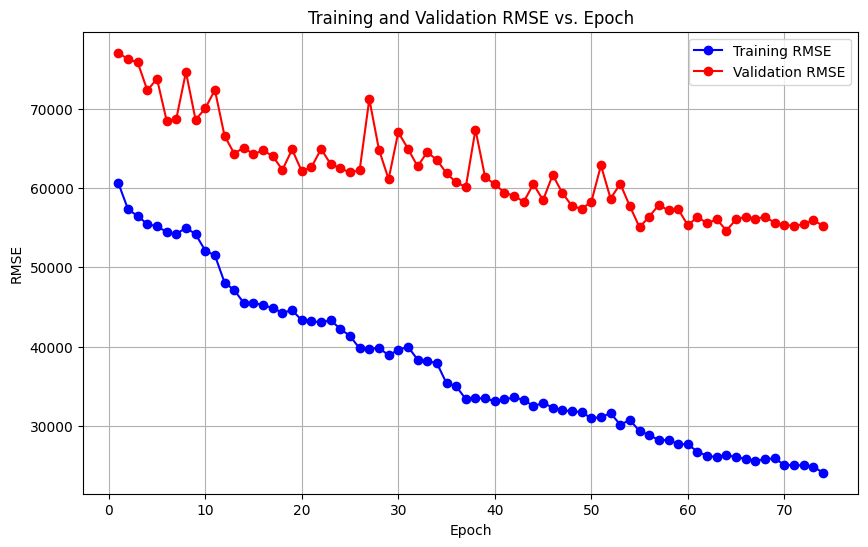

In [ ]:

# -------------------
# 8. Define the Deep CNN Model (as in your original code)
# -------------------

def build_deep_cnn_no_bn(input_shape=(3, 3, 15), output_dim=12):
    model = models.Sequential()

    # Block 1
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))

    # Block 3
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))  # Extra dense layer
    model.add(layers.Dense(output_dim, activation='linear'))

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

model = build_deep_cnn_no_bn(input_shape=(3, 3, 15), output_dim=12)
model.summary()


# -------------------
# 9. Train the Model
# -------------------
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=500,
    batch_size=32,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ],
    verbose=1
)

# -------------------
# 10. Evaluate the Model on the Test Set and Compute NSE and NMSE
# -------------------

# Define NSE and NMSE functions.
def nse_score(y_true, y_pred):
    """Nash-Sutcliffe Efficiency (NSE)"""
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - numerator / denominator

def nmse_score(y_true, y_pred):
    """Normalized Mean Squared Error (NMSE) = MSE / Variance(y_true)"""
    mse = np.mean((y_true - y_pred) ** 2)
    var_true = np.var(y_true)
    return mse / var_true

# Predict on the test set.
y_pred = model.predict(X_test)

# Compute standard metrics.
r2 = r2_score(y_test.flatten(), y_pred.flatten())
mse_val = mean_squared_error(y_test.flatten(), y_pred.flatten())
rmse = np.sqrt(mse_val)
mae_val = mean_absolute_error(y_test.flatten(), y_pred.flatten())

# Compute NSE and NMSE.
nse = nse_score(y_test.flatten(), y_pred.flatten())
nmse = nmse_score(y_test.flatten(), y_pred.flatten())

print("\nTest Metrics:")
print(f"R²: {r2:.4f}")
print(f"MSE: {mse_val:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae_val:.4f}")
print(f"NSE: {nse:.4f}")
print(f"NMSE: {nmse:.4f}")

# -------------------
# 11. Plot Training and Validation RMSE vs. Epoch
# -------------------
epochs = range(1, len(history.history['loss']) + 1)
train_rmse = np.sqrt(history.history['loss'])
val_rmse = np.sqrt(history.history['val_loss'])

plt.figure(figsize=(10,6))
plt.plot(epochs, train_rmse, 'b-o', label='Training RMSE')
plt.plot(epochs, val_rmse, 'r-o', label='Validation RMSE')
plt.title('Training and Validation RMSE vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()